This notebook is performing the Training for the [Human Protein Atlas Image Classification](https://www.kaggle.com/c/human-protein-atlas-image-classification) challange. This challange is a classification challange to identify the different protein types of the human body.
Link to this Notebook on Kaggle: [Link](https://www.kaggle.com/smehta12/modeling-protein-identification)

It uses the extensive funcationality of the Keras library. It generates the required data in batches. It uses the transfer learning of the pre-trained models from the Keras library. Also, it uses the multiple accuracy measures for the classification.

This notebok was on first 50th percentile of the notebook at the time of results submit on Kaggle.

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import cv2
import gc
import random
import tensorflow as tf
import keras.backend as K
import imgaug as ia

from tqdm import tqdm
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras import regularizers
from keras.utils import Sequence
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [5]:
root_dir="/home/shalin/my_projects/protein_atlas"
train_dir=os.path.join(root_dir, "train")
test_dir=os.path.join(root_dir, "test")
train_csv_path=os.path.join(root_dir,"train.csv")

In [6]:
IMAGE_SIZE=224 #256# 512

In [7]:
# read the training csv
train_csv = pd.read_csv(train_csv_path)
print(train_csv.shape)
train_csv.head()

(31072, 2)


,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [8]:
class_names = {
    0:"Nucleoplasm", 1:"Nuclear membrane", 2:"Nucleoli", 3:"Nucleoli fibrillar center", 4:"Nuclear speckles", 
    5:"Nuclear bodies",  6:"Endoplasmic reticulum", 7:"Golgi apparatus", 8:"Peroxisomes", 9:"Endosomes", 
    10:"Lysosomes", 11:"Intermediate filaments", 12:"Actin filaments", 13:"Focal adhesion sites",14:"Microtubules", 
    15:"Microtubule ends", 16:"Cytokinetic bridge", 17:"Mitotic spindle", 18:"Microtubule organizing center", 
    19:"Centrosome", 20:"Lipid droplets", 21:"Plasma membrane", 22:"Cell junctions", 23:"Mitochondria", 
    24:"Aggresome",  25:"Cytosol", 26:"Cytoplasmic bodies", 27:"Rods & rings" 
}

In [9]:
# split the targets in train csv
def split_classes(row):
    for cls_num in row["Target"].split():
        train_csv.loc[row.name, class_names[int(cls_num)]]=1

for cls_num, cls_name in class_names.items():
    train_csv[cls_name]=0

# train_csv["splitted"] = train_csv["Target"].apply(lambda x: i+1 for i in x.split())
train_csv.apply(split_classes, axis=1)
train_csv.head()

#DISABLE BELOW
# train_csv = pd.read_csv(root_dir+"/train_csv.csv")
# train_csv.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0,1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [10]:
# load the data batch wise from the disk on the fly
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class BatchDataGenerator(Sequence):
    # 'Generates data for Keras'
    def __init__(self, paths, labels, batch_size, shape, shuffle = True, augment = False, load_green_only=True, 
                 load_3chnls=False, return_paths=False):
         # 'Initialization'
        self.paths = paths
        self.labels = labels
        self.batch_size = batch_size
        self.shape = shape
        self.shuffle = shuffle
        self.augment = augment
        self.load_green_only = load_green_only
        self.load_3chnls = load_3chnls
        self.on_epoch_end()
        self.return_paths = return_paths
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.paths) / self.batch_size))
    
    def __getitem__(self, idx):
        # Generate indexes of a batch
        indexes = self.indexes[idx * self.batch_size : (idx+1) * self.batch_size]        
        paths = self.paths[indexes]
        X = np.zeros((paths.shape[0], self.shape[0], self.shape[1], self.shape[2]))
        # Generate data
        for i, path in enumerate(paths):
            X[i] = self.__load_image(path)
            
        y = self.labels[indexes]
                
        if self.augment == True:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5), # horizontal flips
                    iaa.Flipud(0.5),
                    iaa.Crop(percent=(0, 0.1)), # random crops
                    # Small gaussian blur with random sigma between 0 and 0.5.
                    # But we only blur about 50% of all images.
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    # Strengthen or weaken the contrast in each image.
                    iaa.ContrastNormalization((0.75, 1.5)),
                    # Add gaussian noise.
                    # For 50% of all images, we sample the noise once per pixel.
                    # For the other 50% of all images, we sample the noise per pixel AND
                    # channel. This can change the color (not only brightness) of the
                    # pixels.
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    # Make some images brighter and some darker.
                    # In 20% of all cases, we sample the multiplier once per channel,
                    # which can end up changing the color of the images.
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    # Apply affine transformations to each image.
                    # Scale/zoom them, translate/move them, rotate them and shear them.
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])], random_order=True)

            X = np.concatenate((X, seq.augment_images(X),  seq.augment_images(X)), 0)#, seq.augment_images(X), seq.augment_images(X)), 0)
            y = np.concatenate((y, y, y),0) # y, y), 0)
            
        if self.return_paths:
            return paths, X, y
        else:
            return X, y
    
    def __load_image(self, path):
        if self.load_green_only:
            im = cv2.imread(path + '_green.png')
            cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
            im.resize(IMAGE_SIZE, IMAGE_SIZE, 1)
        elif load_3chnls:
            all_images = np.empty((512,512,3))
            reds = plt.imread(path + '_red.png')
            greens = plt.imread(path + '_green.png')
            blues = plt.imread(path + '_blue.png')
             
            all_images[:,:,0] = reds
            all_images[:,:,1] = greens
            all_images[:,:,2] = blues
            
            im = all_images.reshape(all_images.shape[0], all_images.shape[0], 3)
            im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
        else:
            all_images = np.empty((512,512,4))
            all_images[:,:,0] = cv2.imread(path + '_red.png')
            all_images[:,:,1] = cv2.imread(path + '_green.png')
            all_images[:,:,2] = cv2.imread(path + '_blue.png')
            all_images[:,:,3] = cv2.imread(path + '_yellow.png')

            # define transformation matrix
            # note that yellow is made usign red and green
            # but you can tune this color conversion yourself
            T = np.array([
                #r g y b
                [1,0,1,0],
                [0,1,1,0],
                [0,0,0,1]])
            
            rgb_image = np.matmul(all_images.reshape(-1, 4), np.transpose(T))
            rgb_image = rgb_image.reshape(all_images.shape[0], all_images.shape[0], 3)
            rgb_image = np.clip(rgb_image, 0, 1)
            
            
            im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
        return im
    
    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        for item in (self[i] for i in range(len(self))):
            yield item
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [11]:
# Load the images in train and test
import platform

if platform.system() == 'Windows':
    train_csv["train_paths"] =  train_dir + "\\" + train_csv["Id"].astype(str)
else:
    train_csv["train_paths"] =  train_dir + "/" + train_csv["Id"].astype(str)

gc.collect()
shuffle(train_csv)

MAX_IMG_FOR_MODELING = 31072 #15000 # choosing only this much images to avoid memory error or timeout error
shuffle(train_csv)
subset_data=train_csv[:MAX_IMG_FOR_MODELING]

train_paths, valid_paths, train_labels, valid_labels = train_test_split(subset_data["train_paths"].values, 
                                                                    subset_data[list(class_names.values())].values, 
                                                                    test_size=0.25)
                                                                    #stratify=subset_data[class_names.values()].values)
print(train_paths.shape)
print(train_labels.shape)
print(valid_paths.shape)
print(valid_labels.shape)

print(train_paths[:5])
print(train_labels[:5])

(23304,)
(23304, 28)
(7768,)
(7768, 28)
['/home/shalin/my_projects/protein_atlas/train/369de974-bba0-11e8-b2b9-ac1f6b6435d0'
 '/home/shalin/my_projects/protein_atlas/train/af3f6482-bbc5-11e8-b2bc-ac1f6b6435d0'
 '/home/shalin/my_projects/protein_atlas/train/eac7a5fe-bba3-11e8-b2b9-ac1f6b6435d0'
 '/home/shalin/my_projects/protein_atlas/train/e74f735c-bbc1-11e8-b2bb-ac1f6b6435d0'
 '/home/shalin/my_projects/protein_atlas/train/502a2838-bbac-11e8-b2ba-ac1f6b6435d0']
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]]


(28, 1)
                               counts
Nucleoplasm                      9678
Nuclear membrane                  932
Nucleoli                         2685
Nucleoli fibrillar center        1147
Nuclear speckles                 1396
Nuclear bodies                   1896
Endoplasmic reticulum             755
Golgi apparatus                  2090
Peroxisomes                        44
Endosomes                          28
Lysosomes                          15
Intermediate filaments            836
Actin filaments                   510
Focal adhesion sites              399
Microtubules                      800
Microtubule ends                   18
Cytokinetic bridge                413
Mitotic spindle                   156
Microtubule organizing center     699
Centrosome                       1111
Lipid droplets                    119
Plasma membrane                  2845
Cell junctions                    603
Mitochondria                     2227
Aggresome                         256
Cyto

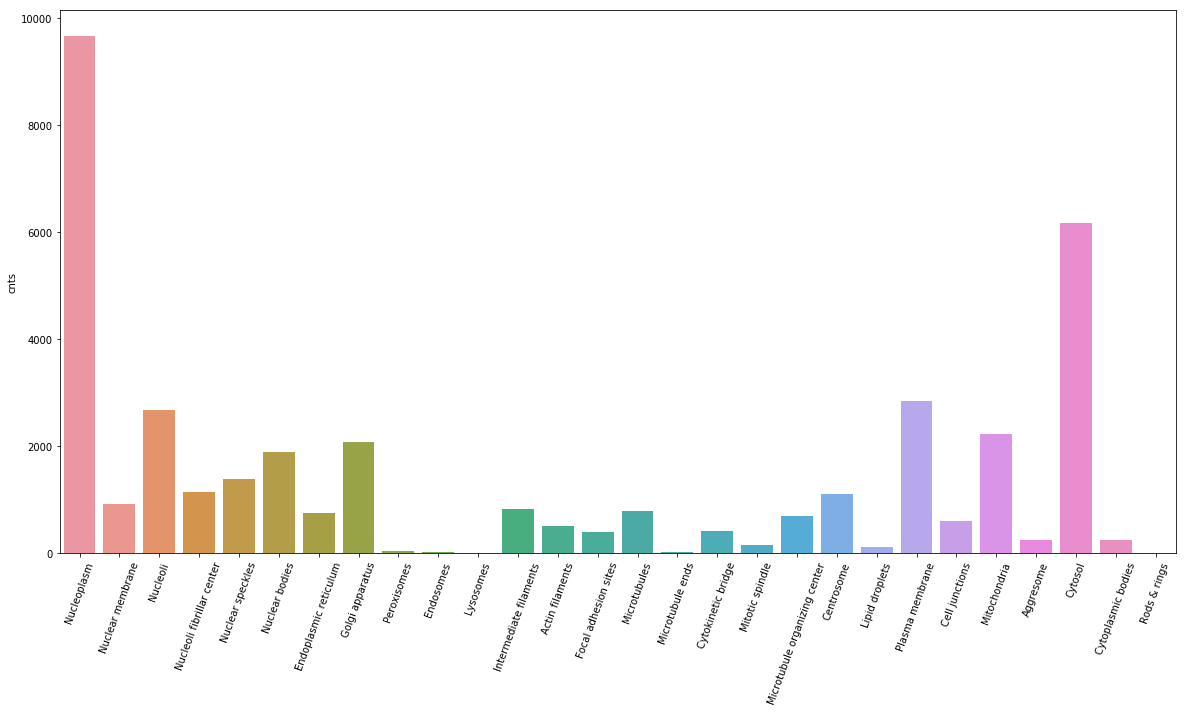

(28, 1)
                               counts
Nucleoplasm                      3207
Nuclear membrane                  322
Nucleoli                          936
Nucleoli fibrillar center         414
Nuclear speckles                  462
Nuclear bodies                    617
Endoplasmic reticulum             253
Golgi apparatus                   732
Peroxisomes                         9
Endosomes                          17
Lysosomes                          13
Intermediate filaments            257
Actin filaments                   178
Focal adhesion sites              138
Microtubules                      266
Microtubule ends                    3
Cytokinetic bridge                117
Mitotic spindle                    54
Microtubule organizing center     203
Centrosome                        371
Lipid droplets                     53
Plasma membrane                   932
Cell junctions                    199
Mitochondria                      738
Aggresome                          66
Cyto

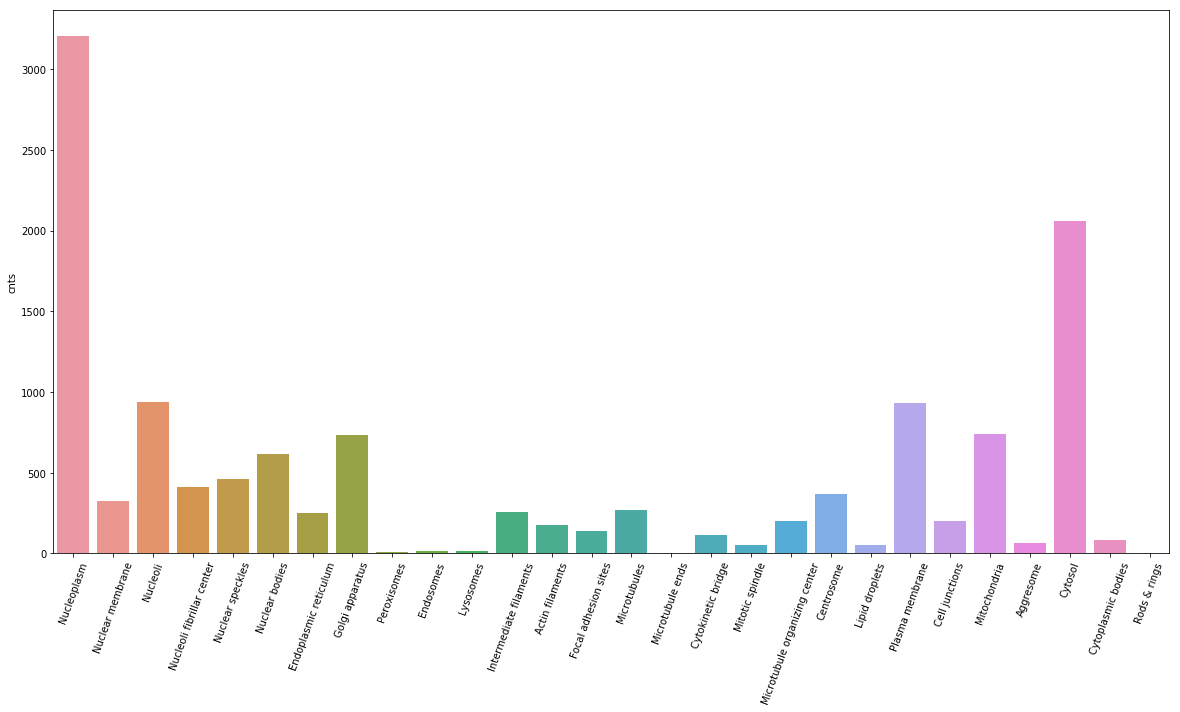

In [12]:
# check class wise train and valid distrib
tc = train_csv.set_index("Id")
train_ids = []
valid_ids = []

def get_distrib(dataset, lst):
    for path in dataset:
        lst.append(path.split(os.path.sep)[-1])
        
    data = train_csv[train_csv["Id"].isin(lst)]
    counts=data[list(class_names.values())].sum()
    counts = counts.to_frame("cnts")
    plt.figure(figsize=(20, 10))
    sns.barplot(counts.index, counts.cnts)
    plt.xticks(rotation=70)
    
    counts.columns = ["counts"]
    print(counts.shape)
    print(counts)
    return counts
        
td = get_distrib(train_paths, train_ids)
plt.show()

vd = get_distrib(valid_paths, valid_ids)
plt.show()


In [13]:
y_integers = np.argmax(train_labels, axis=1)

weights = train_labels.shape[0]/(len(class_names)*td["counts"].values)
class_weights = {}
for cls_num, w in zip(class_names.keys(),weights):
    class_weights[cls_num] = w

print(class_weights)

{0: 0.08599769728102029, 1: 0.8930104230533416, 2: 0.309976057462091, 3: 0.7256196288454353, 4: 0.5961932050757266, 5: 0.43896925858951175, 6: 1.1023651844843898, 7: 0.39822282980177715, 8: 18.915584415584416, 9: 29.724489795918366, 10: 55.48571428571429, 11: 0.995557074504443, 12: 1.6319327731092437, 13: 2.0859291084854994, 14: 1.0403571428571428, 15: 46.23809523809524, 16: 2.0152196471809063, 17: 5.335164835164835, 18: 1.190680564071122, 19: 0.7491320560627491, 20: 6.9939975990396155, 21: 0.29254330906351994, 22: 1.3802416488983653, 23: 0.3737250625441016, 24: 3.2511160714285716, 25: 0.1348704771164664, 26: 3.4250440917107583, 27: 83.22857142857143}


In [14]:
# Data generation

batch_size=16

load_green_only = False
load_3chnls = True
img_shape = (IMAGE_SIZE, IMAGE_SIZE, 1) if load_green_only else (IMAGE_SIZE, IMAGE_SIZE, 3) \
                                        if load_3chnls else (IMAGE_SIZE, IMAGE_SIZE, 3)
print(img_shape)
train_gen = BatchDataGenerator(train_paths, train_labels, batch_size, img_shape, load_green_only=load_green_only, 
                               load_3chnls=load_3chnls, augment=True, shuffle=False)
val_gen = BatchDataGenerator(valid_paths, valid_labels, batch_size, img_shape, load_green_only=load_green_only, 
                             load_3chnls=load_3chnls, augment=True, shuffle=False)

(224, 224, 3)


In [15]:
model_dir = './model'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
checkpoint = ModelCheckpoint(os.path.join(model_dir, 'base.model'), monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)
reduce_LR_on_plateu = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [16]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [17]:
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D , BatchNormalization, \
                        Input, GaussianNoise, GlobalMaxPooling2D, GlobalAveragePooling2D
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [18]:
# Train vs Validation accuracy and loss

def loss_over_epochs(model, loss_type='loss', add_valid=True):
    hist=model.history.history
    plt.plot(list(range(epochs)), hist['loss'], color="blue", label="train")
    if add_valid:
        plt.plot(list(range(epochs)), hist['val_loss'], color="orange", label="valid")
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.title("Losses over the Epochs")

# accuracy vs epochs
def acc_over_epochs(model, acc_type='acc', add_valid=True):
    hist=model.history.history
    plt.plot(list(range(epochs)), hist[acc_type], color="blue", label="train")
    if add_valid:
        plt.plot(list(range(epochs)), hist["val_"+acc_type], color="orange", label="valid")
    plt.xlabel("Epochs")
    plt.ylabel(acc_type)
    plt.legend()
    plt.title(acc_type + " over the Epochs")

In [19]:
vgg_model = VGG16(include_top=False, input_shape=img_shape)
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [20]:
gaus_noise = 0.1
DENSE_COUNT = 1024

vgg_model.trainable = False
in_layer = Input(shape=(img_shape))
noise_layer =  GaussianNoise(0.1)(in_layer)
features_layer = vgg_model(noise_layer)
batch_norm = BatchNormalization()(features_layer)
#gmp_dr = GlobalMaxPooling2D()(batch_norm)
x = GlobalAveragePooling2D()(batch_norm)
x = Dense(DENSE_COUNT, activation = 'relu')(x)
predictions = Dense(len(class_names), activation = 'sigmoid')(x)
model = Model(inputs = [in_layer], outputs = [predictions], name = 'vgg_gnoise_model')

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 512)         2048      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_2 (Dense)              (None, 28)                28700     
Total para

In [22]:
opt = Adam(lr=0.01)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy", f1])
gc.collect()

16904

In [23]:
epochs = 30

use_multiprocessing = True # DO NOT COMBINE MULTIPROCESSING WITH CACHE! 
workers = 6 # DO NOT COMBINE MULTIPROCESSING WITH CACHE! 

model.fit_generator(
                    train_gen,
                    steps_per_epoch=len(train_gen), 
                    validation_data=val_gen,
                    validation_steps=50,
                    epochs=epochs,
                    use_multiprocessing=use_multiprocessing,
                    workers=workers,
                    class_weight=class_weights,
                    callbacks=[checkpoint, reduce_LR_on_plateu])

Epoch 1/30
1456/1456 [==============================] - 353s 242ms/step - loss: 0.1071 - acc: 0.9400 - f1: 0.0053 - val_loss: 0.2404 - val_acc: 0.9407 - val_f1: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.24035, saving model to ./model/base.model
Epoch 2/30
1456/1456 [==============================] - 336s 231ms/step - loss: 0.0977 - acc: 0.9413 - f1: 0.0016 - val_loss: 0.2648 - val_acc: 0.9302 - val_f1: 0.0181

Epoch 00002: val_loss did not improve from 0.24035
Epoch 3/30
1456/1456 [==============================] - 330s 227ms/step - loss: 0.0984 - acc: 0.9414 - f1: 0.0020 - val_loss: 0.2273 - val_acc: 0.9421 - val_f1: 0.0000e+00

Epoch 00003: val_loss improved from 0.24035 to 0.22726, saving model to ./model/base.model
Epoch 4/30
1456/1456 [==============================] - 332s 228ms/step - loss: 0.0986 - acc: 0.9414 - f1: 0.0013 - val_loss: 0.2013 - val_acc: 0.9407 - val_f1: 0.0014

Epoch 00004: val_loss improved from 0.22726 to 0.20127, saving model to ./model/base.mo

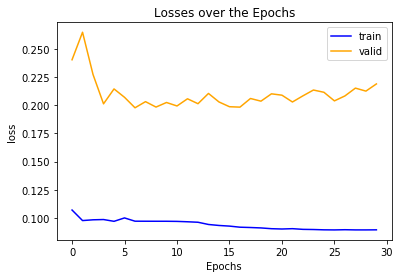

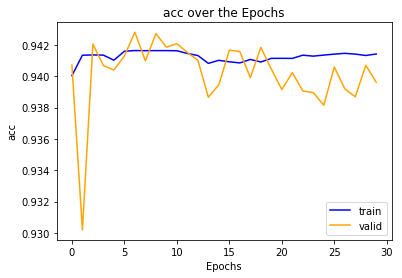

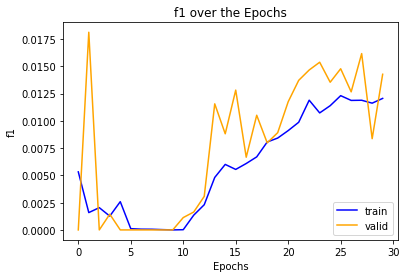

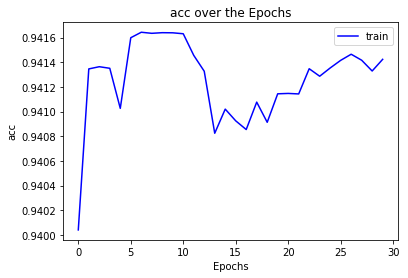

In [24]:
loss_over_epochs(model)
plt.show()
acc_over_epochs(model)
plt.show()
acc_over_epochs(model, acc_type="f1")
plt.show()
acc_over_epochs(model, add_valid=False)

## Test Data and Submission

In [25]:
# Get the test data
test_paths = []
sample_test_labels = []

sample_submit = os.path.join(root_dir, 'sample_submission.csv')
data = pd.read_csv(sample_submit)
    
for name in data['Id']:
    y = np.ones(28)
    test_paths.append(os.path.join(test_dir, name))
    sample_test_labels.append(y)

test_paths = np.array(test_paths)
sample_test_labels = np.array(sample_test_labels)

print(test_paths[:3])
print(sample_test_labels[:3])

['/home/shalin/my_projects/protein_atlas/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'
 '/home/shalin/my_projects/protein_atlas/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'
 '/home/shalin/my_projects/protein_atlas/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0']
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]]


In [26]:
def load_test_images(load_all=False):
    """
    If load_all==False then it will return the iterator or it will return the all test images in numpy array.
    """
    test_gen = BatchDataGenerator(test_paths, sample_test_labels, 1, img_shape, load_green_only=load_green_only, 
                               load_3chnls=load_3chnls, augment=False, shuffle=False, return_paths=True)
    if load_all:
        images = []
        for img in test_gen:
            images.append(img)
        
        return np.array(images)
    
    return test_gen

In [27]:
full_val_pred = np.empty((0, 28))
for i in tqdm(range(len(val_gen))): 
    im, lbl = val_gen[i]
    scores = model.predict(im)
    full_val_pred = np.append(full_val_pred, scores, axis=0)
print(full_val_pred.shape)

100%|██████████| 485/485 [03:49<00:00,  2.12it/s]

(23280, 28)


In [28]:
# Take "perc" percentile score of each class a threshold
perc = 85

thresholds = np.empty(len(class_names))
for i in range(len(class_names)):
    thresholds[i] = np.percentile(full_val_pred[:,i], perc)
print('Probability threshold for each class score:')
print(thresholds)

Probability threshold for each class score:
[0.17692961 0.06348985 0.15631423 0.0916313  0.13390496 0.09701963
 0.05989491 0.06612776 0.07011564 0.09233357 0.03715436 0.06225269
 0.04773318 0.05503295 0.08423697 0.0005114  0.02326799 0.02301825
 0.06041699 0.05776544 0.07234424 0.09911635 0.0389252  0.0688813
 0.05499392 0.21464622 0.04906948 0.00508387]


In [29]:
preds = {"Id":[], "Predicted":[]}


test_images = load_test_images()

i=0
for img_data in tqdm(test_images):
    paths, test_imgs, labels = img_data
    score = model.predict(test_imgs)
    tmp = []
    for i in range(len(class_names)):
        if score[0][i] >= thresholds[i]:
            tmp.append(str(i))
    preds["Id"].append(paths[0].split(os.path.sep)[-1])
    preds["Predicted"].append(" ".join(tmp))

100%|██████████| 11702/11702 [03:48<00:00, 51.17it/s]


In [30]:
submit = pd.DataFrame(preds)
print(submit.shape)
print(submit.head(5))
submit.to_csv("submission1.csv", index=False)

(11702, 2)
                                     Id         Predicted
0  00008af0-bad0-11e8-b2b8-ac1f6b6435d0               2 3
1  0000a892-bacf-11e8-b2b8-ac1f6b6435d0                26
2  0006faa6-bac7-11e8-b2b7-ac1f6b6435d0             12 21
3  0008baca-bad7-11e8-b2b9-ac1f6b6435d0  0 2 4 5 15 16 17
4  000cce7e-bad4-11e8-b2b8-ac1f6b6435d0             11 23
